#Stock Price Forecasting using ARIMA model
* We used 3 stocks to test our forecasting model- EXX5, IQQE and IUS4.
* Data sets are collected from [Yahoo Finance](https://finance.yahoo.com/)
* Time Window: May 2021 to May 2022

#Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.stats import normaltest
from statsmodels.tsa.stattools import acf,pacf
#from pmdarima.arima import auto_arima
import scipy.interpolate as sci
import scipy.optimize as sco
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import scipy.optimize as sco

#Importing Data Sets

In [ ]:
df1 = pd.read_csv("/content/EXX5.DE.csv")
df2 = pd.read_csv("/content/IQQE.DE.csv")
df3 = pd.read_csv("/content/IUS4.DE.csv")

#Formatting Data Sets

##Setting Date as the index of the DataFrame.

In [ ]:
for df in (df1, df2, df3):
  df.set_index("Date", inplace=True)
  df.index = pd.to_datetime(df.index)

##Merging 3 datasets into 1 DataFrame for simplicity

In [ ]:
df=pd.DataFrame({"EXX5":[],"IQQE":[],"IUS4":[]})
symbols=['EXX5','IQQE','IUS4']
df.EXX5=df1.Close
df.IQQE=df2.Close
df.IUS4=df3.Close

In [ ]:
df.head()

,EXX5,IQQE,IUS4
Date,,,
2021-05-03,70.529999,43.273998,37.735001
2021-05-04,70.709999,42.717999,37.435001
2021-05-05,71.250000,43.243999,38.125000
2021-05-06,71.290001,43.256001,37.785000
2021-05-07,71.430000,43.580002,38.040001


#Initial Plotting

##Stock price

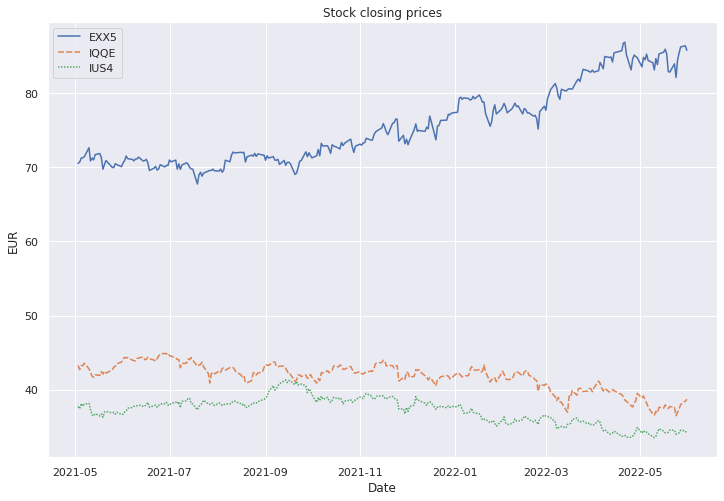

In [ ]:
plt.figure(figsize=(12,8))
sns.set_theme(style="darkgrid")
sns.lineplot(data=df)
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('EUR')
plt.title('Stock closing prices')
plt.show()

##Seasonal Decomposition

<Figure size 432x288 with 0 Axes>

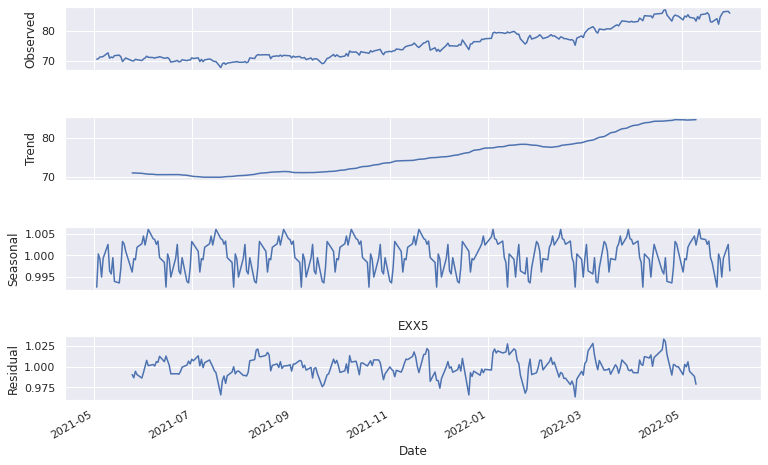

<Figure size 432x288 with 0 Axes>

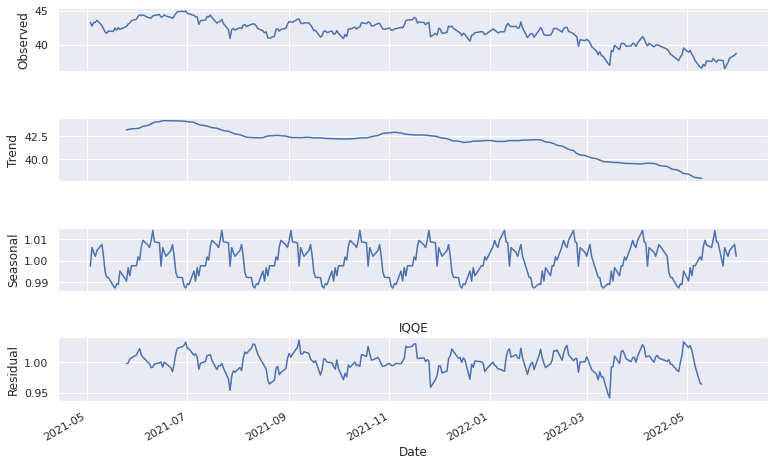

<Figure size 432x288 with 0 Axes>

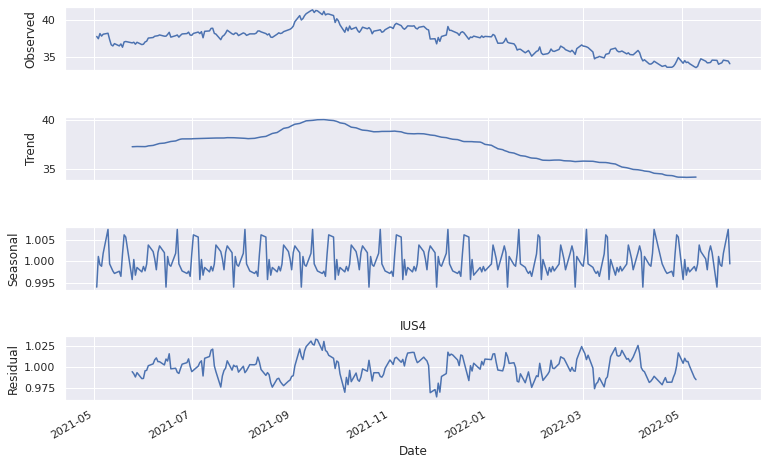

In [ ]:
for i in symbols[0:]:
    result = seasonal_decompose(df[i], model='multiplicative', freq=30)
    fig = plt.figure()  
    fig = result.plot()  
    plt.title(i) 
    fig.set_size_inches(12, 8)
plt.show()

We observed trend and seasonality in our data.

#Checking close price data for normality and stationarity
* ADF test
* Normality Test

##ADF test
Augmented Dickey Fuller(ADF) test is a common statistical test used to test whether a given Time series is stationary or not.

In [ ]:
for i in symbols:
  print([i])
  result = adfuller(df[i], autolag='AIC')
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
      print('\t%s: %.3f' % (key, value))
  if result[0] < result[4]["5%"]:
      print ("Reject Null Hypothesis. So, Time Series is Stationary")
  else:
      print ("Failed to reject Null Hypothesis. So, Time Series is Not-Stationary")
  print("\n")

['EXX5']
ADF Statistic: 0.138976
p-value: 0.968624
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.572
Failed to reject Null Hypothesis. So, Time Series is Not-Stationary


['IQQE']
ADF Statistic: -1.913441
p-value: 0.325765
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572
Failed to reject Null Hypothesis. So, Time Series is Not-Stationary


['IUS4']
ADF Statistic: -0.731755
p-value: 0.838352
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.572
Failed to reject Null Hypothesis. So, Time Series is Not-Stationary




##Normality Test

In [ ]:
for i in symbols:
    print([i])
    stat, p = normaltest(df[i])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    alpha = 0.05
    if p > alpha:
        print('Data is normally distributed (fail to reject H0)')
    else:
        print('Data is not normally distributed(reject H0)')
    print('\n')

['EXX5']
Statistics=46.838, p=0.000
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.572
Data is not normally distributed(reject H0)


['IQQE']
Statistics=28.915, p=0.000
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.572
Data is not normally distributed(reject H0)


['IUS4']
Statistics=8.137, p=0.017
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.572
Data is not normally distributed(reject H0)




#log Transformation
The log transformation can be used to make highly skewed distributions less skewed.

In [ ]:
df_log = np.log(df / df.shift(1))

In [ ]:
df_log.head()

,EXX5,IQQE,IUS4
Date,,,
2021-05-03,NaN,NaN,NaN
2021-05-04,0.002549,-0.012932,-0.007982
2021-05-05,0.007608,0.012238,0.018264
2021-05-06,0.000561,0.000278,-0.008958
2021-05-07,0.001962,0.007462,0.006726


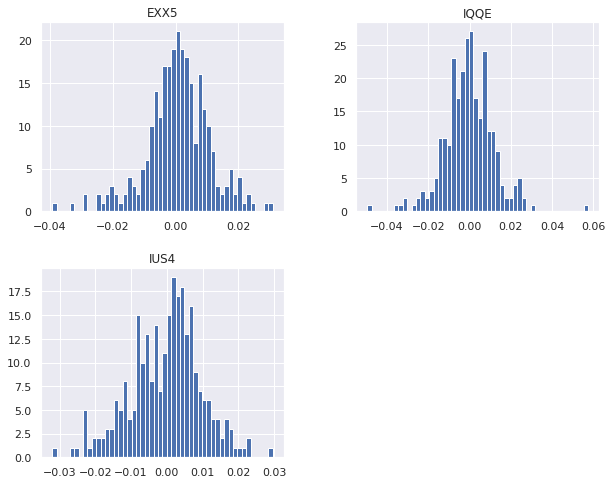

In [ ]:
df_log.hist(bins=50, figsize=(10, 8))
plt.show()

In [ ]:
df_log2 = df_log.dropna()

In [ ]:
df_log2.head()

,EXX5,IQQE,IUS4
Date,,,
2021-05-04,0.002549,-0.012932,-0.007982
2021-05-05,0.007608,0.012238,0.018264
2021-05-06,0.000561,0.000278,-0.008958
2021-05-07,0.001962,0.007462,0.006726
2021-05-10,0.016798,-0.017663,0.003412


#Using the log transformed data to do ADF and Normality test


##ADF test

In [ ]:
for i in symbols:
  print([i])
  result = adfuller(df_log2[i], autolag='AIC')
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
      print('\t%s: %.3f' % (key, value))
  if result[0] < result[4]["5%"]:
      print ("Reject Null Hypothesis. So, Time Series is Stationary")
  else:
      print ("Failed to reject Null Hypothesis. So, Time Series is Non-Stationary")
  print("\n")

['EXX5']
ADF Statistic: -14.263448
p-value: 0.000000
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572
Reject Null Hypothesis. So, Time Series is Stationary


['IQQE']
ADF Statistic: -11.171059
p-value: 0.000000
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.572
Reject Null Hypothesis. So, Time Series is Stationary


['IUS4']
ADF Statistic: -11.457322
p-value: 0.000000
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.572
Reject Null Hypothesis. So, Time Series is Stationary




##Normality Test

In [ ]:
for i in symbols:
    print([i])
    stat, p = normaltest(df_log2[i])
    print('Test Statistics=%.3f, p=%.3f' % (stat, p))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    alpha = 0.05
    if p > alpha:
        print('Data is normally distributed (fail to reject H0)')
    else:
        print('Data is not normally distributed(reject H0)')
    print('\n')

['EXX5']
Test Statistics=17.306, p=0.000
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.572
Data is not normally distributed(reject H0)


['IQQE']
Test Statistics=21.444, p=0.000
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.572
Data is not normally distributed(reject H0)


['IUS4']
Test Statistics=3.795, p=0.150
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.572
Data is normally distributed (fail to reject H0)




We can see that now the data for all three stocks is stationary. But, even if IUS4 is normally distributed, the other two are not. Have to look into why this is happening.

###QQ plot
Quantile-Quantile Plot

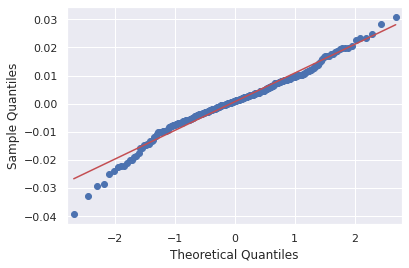

In [ ]:
fig = sm.qqplot(df_log2['EXX5'], line='s')
plt.show()

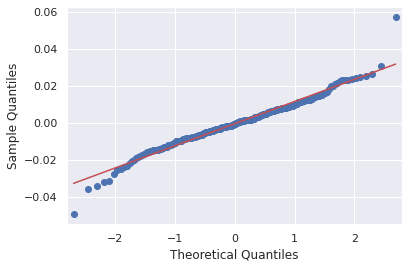

In [ ]:
fig = sm.qqplot(df_log2['IQQE'], line='s')
plt.show()

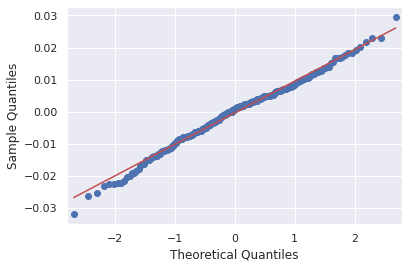

In [ ]:
fig = sm.qqplot(df_log2['IUS4'], line='s')
plt.show()

For EXX5 and IQQE, We can see that most of the points lie mostly along the straight diagonal line with some minor deviations along each of the tails.

Based on this plot, we could assume that set of data for EXX5 and IQQE is normally distributed.

#Constructing an ARIMA model with auto-fitting parameters (p,d,q)

In [ ]:
!pip install pmdarima

In [ ]:
from pmdarima import auto_arima

In [ ]:
def arima_auto(arr): 
    train_data=pd.DataFrame() # splitting into test and train data
    test_data=pd.DataFrame() 
    plt.figure(figsize=(12,8))
    for i, sym in enumerate(symbols): # for all 3 stocks
        train_data[sym], test_data[sym] = df[sym][1:int(len(df[sym])*0.8)], df[sym][int(len(df)*0.8):]
        model = auto_arima(train_data[sym], trace=True, error_action='ignore', suppress_warnings=True)
        model.fit(train_data[sym]) # fitting the model
        forecast = model.predict(n_periods=len(test_data[sym]))
        forecast = pd.DataFrame(forecast,index = test_data.index) # plot the predictions for validation set
        plt.plot(train_data, label='Train {}'.format(sym))
        plt.plot(test_data, label='Test {}'.format(sym))
        plt.plot(forecast, label='Prediction {}'.format(sym))
    plt.title('Stocks Price Prediction\n')
    plt.xlabel('Date')
    plt.ylabel('Actual Stock Price')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
#    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=481.028, Time=2.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=488.093, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=482.770, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=480.863, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=486.704, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=478.953, Time=0.60 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=479.371, Time=1.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=479.167, Time=1.60 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=480.848, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=481.961, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=479.624, Time=0.21 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 7.170 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=288.546, Time=2.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=288.071, Time=0

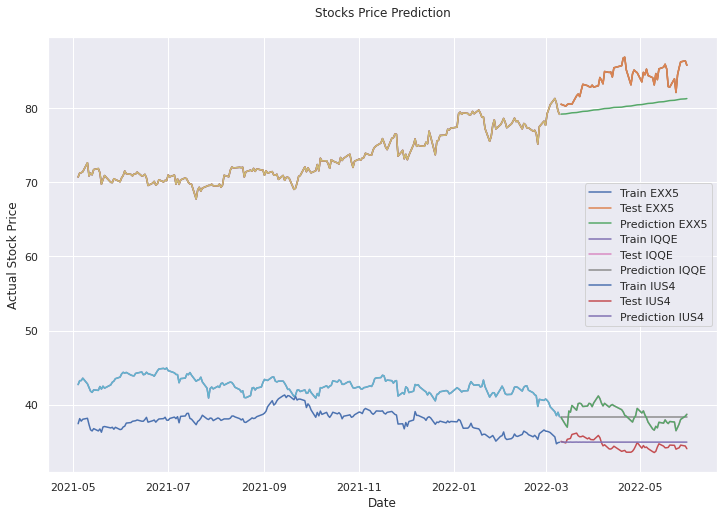

In [ ]:
arima_auto(df)

Best fit ARIMA (p,d,q) parameters:
* EXX5 : (1,1,1)
* IQQE : (0,1,0)
* IUS4 : (1,1,1)